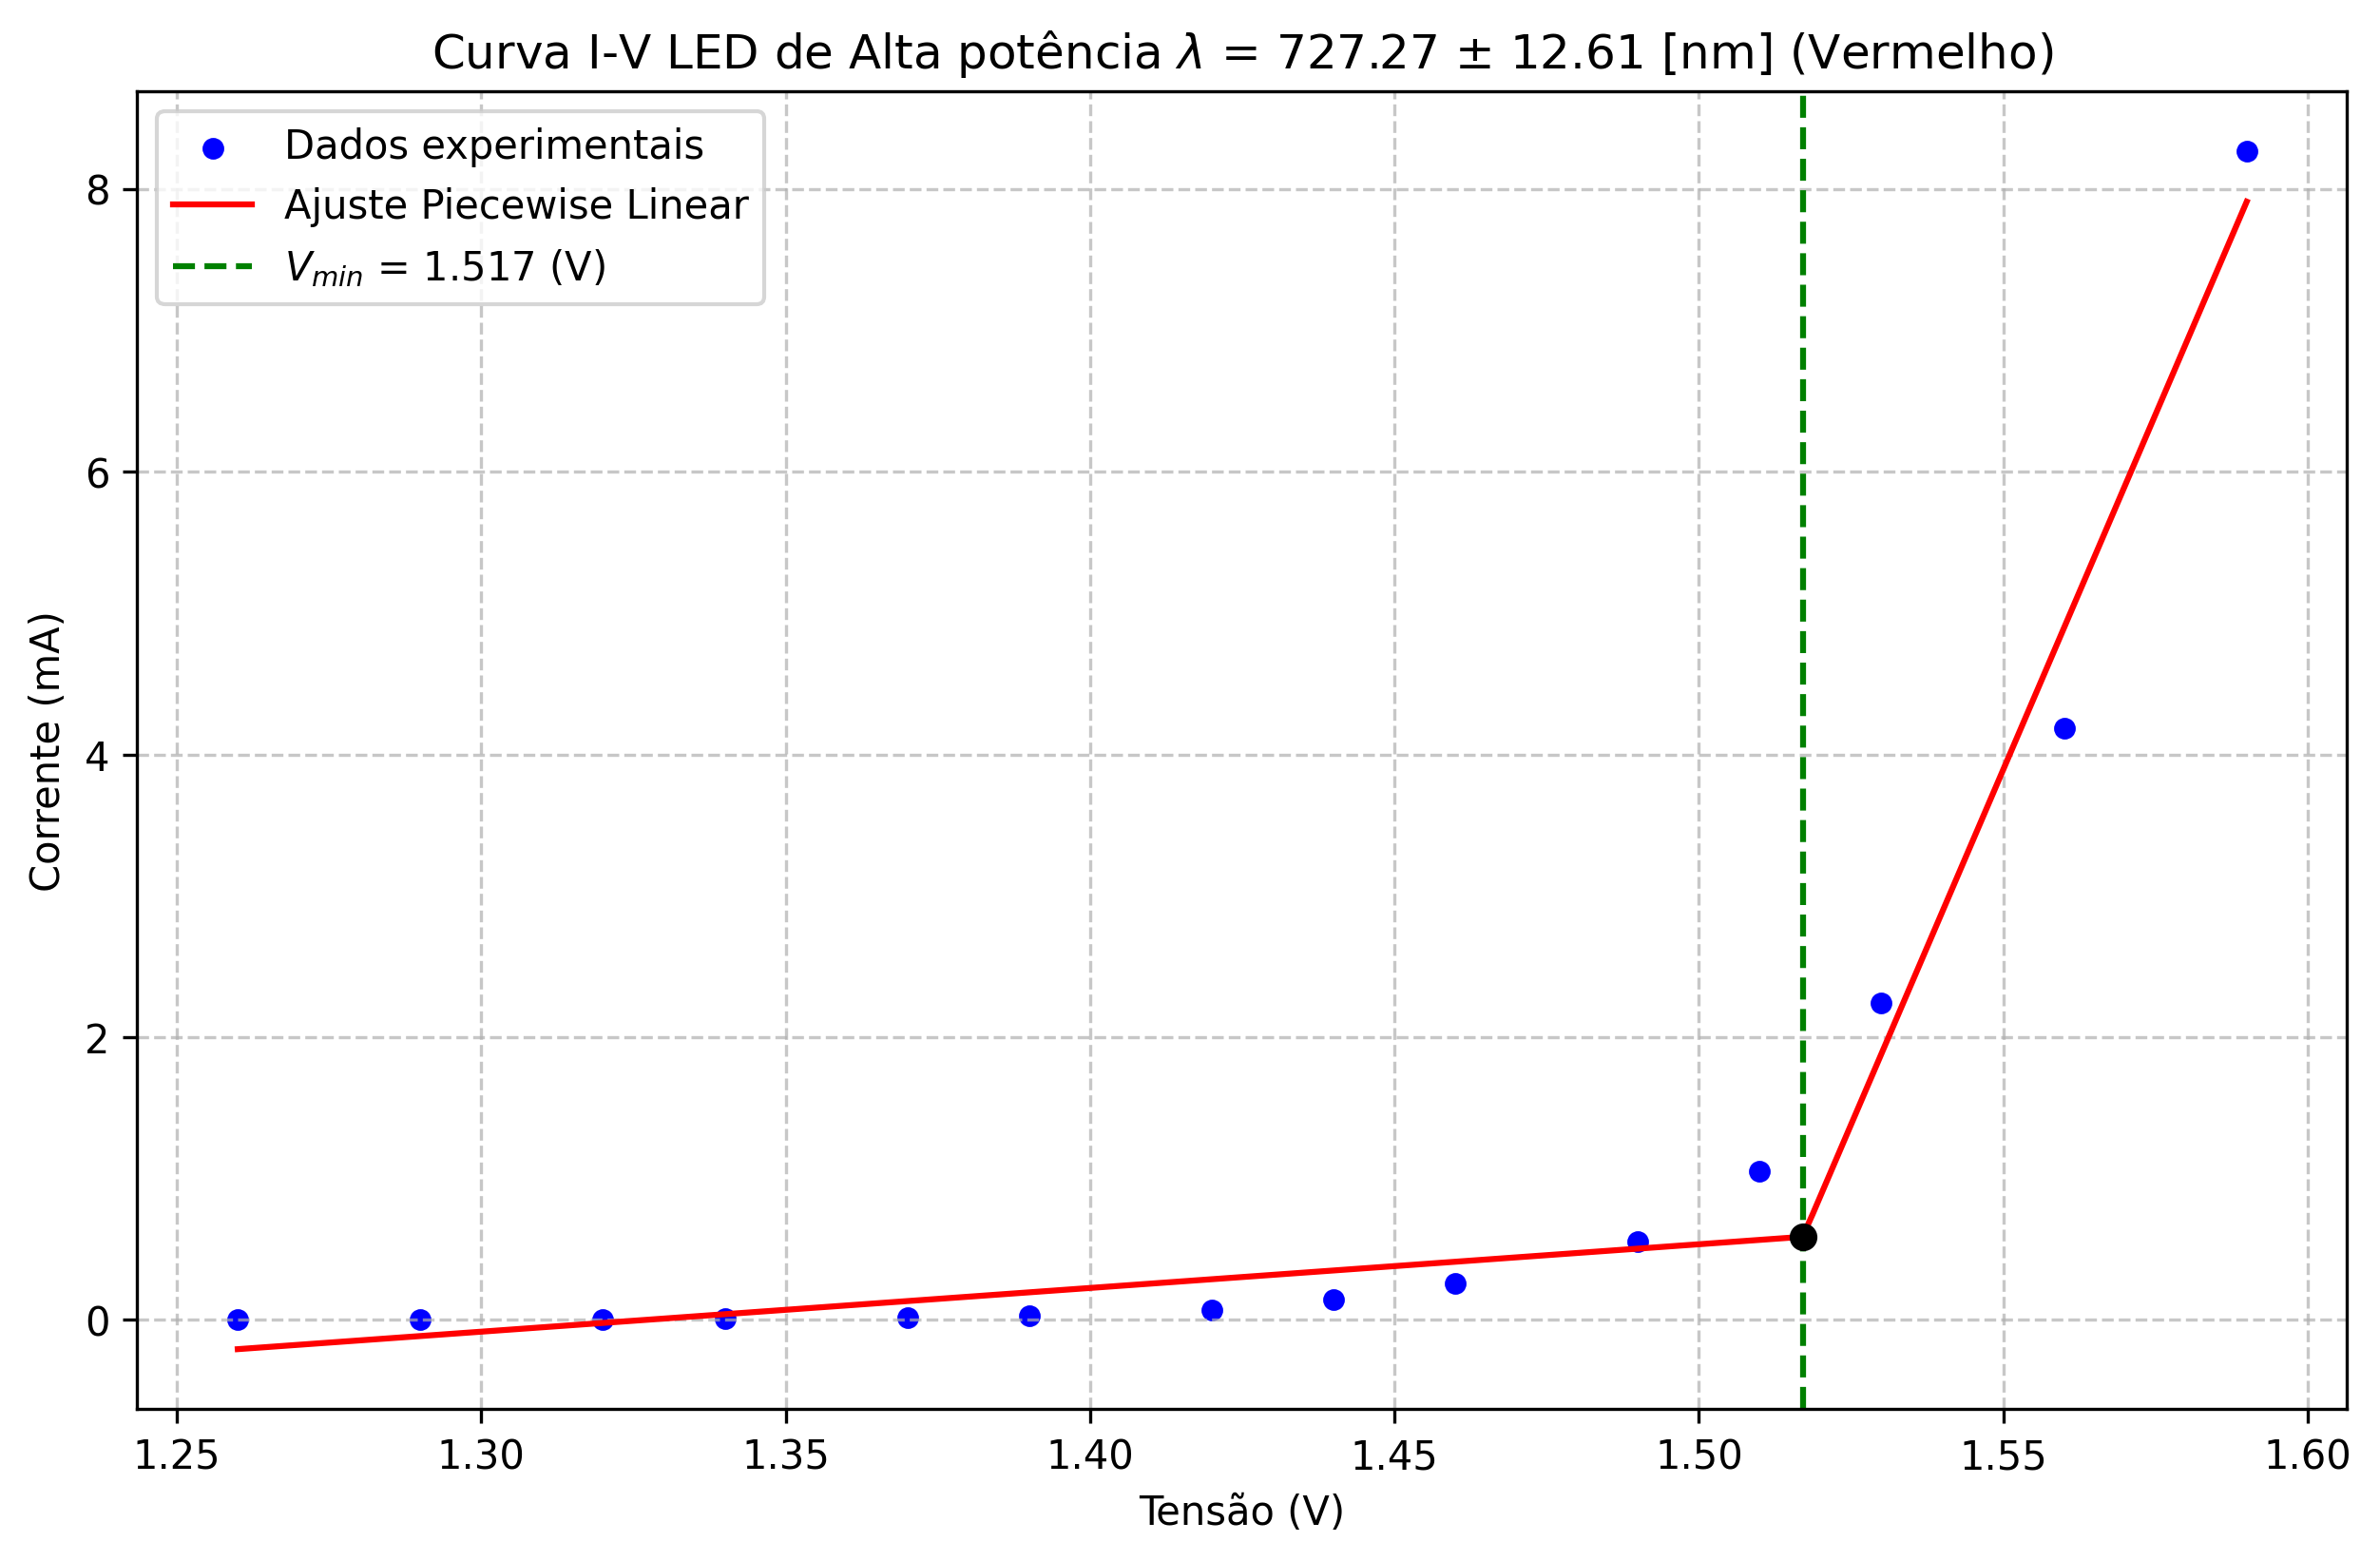

Ponto de transição (x0): 1.5171070671812452


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

# Caminho do arquivo
caminho = 'Dados/IV-A-1/led6-a1-iv.csv'
# Ler CSV
df = pd.read_csv(caminho, sep=',')

# Extrair colunas como numpy arrays
x = df['tensao (V) (0,001)'].to_numpy()
y = df['corrente (mA) (0,0001)'].to_numpy()

# Aredonda os valores
x = np.round(x, 2)
y = np.round(y, 3)

# Função piecewise linear
def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(
        x, 
        [x < x0, x >= x0], 
        [lambda x: k1*x + y0 - k1*x0, 
         lambda x: k2*x + y0 - k2*x0]
    )

# Ajuste (chute inicial)
p0 = [np.median(x), np.median(y), 0.1, 1]
p , e = optimize.curve_fit(piecewise_linear, x, y, p0=p0)

# Extrair parâmetros
x0, y0, k1, k2 = p

# Guardar ponto de transição em variável
transicao = (x0, y0)

# Gerar curva ajustada
xd = np.linspace(min(x), max(x), 200)
yd = piecewise_linear(xd, *p)

# Plot
plt.figure(figsize=(10,6), dpi=300)
plt.scatter(x, y, label="Dados experimentais", color="blue", s=20)
plt.plot(xd, yd, label="Ajuste Piecewise Linear", color="red")
plt.axvline(x0, color="green", linestyle="--", label=r"$V_{min}$"+f" = {x0:.3f} (V)")
plt.plot(x0, y0, "ko")
plt.xlabel('Tensão (V)')
plt.ylabel('Corrente (mA)')
plt.title(r'Curva I-V LED de Alta potência $\lambda$ = 727.27 $\pm$ 12.61 [nm] (Vermelho)')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# Mostrar no console
print("Ponto de transição (x0):", transicao[0])


Backup criado: Dados/Espectro-A-1/led4-a1-espectro.txt.old
Arquivo atualizado e salvo em: Dados/Espectro-A-1/led4-a1-espectro.txt
Pico em x = 559.7000
Meia altura = 0.5000
Limite de distância = 87.2475


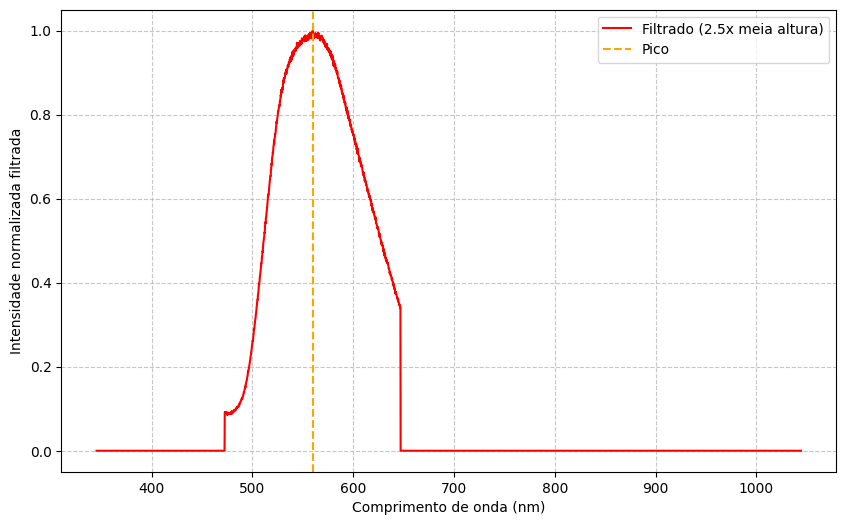

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil

def processar_dados_e_salvar_com_backup(caminho, fator=2.5):
    """
    Processa os dados do espectro, faz backup do arquivo original (.old),
    aplica o corte baseado em 2.5x meia altura e sobrescreve o original
    no formato original (apenas x e y_filtrado, sem header).
    
    Parâmetros:
        caminho (str): caminho para o arquivo de entrada
        fator (float): multiplicador da meia altura para definir o limite
    """
    # --- Fazer backup do arquivo original ---
    backup_path = caminho + ".old"
    shutil.copy(caminho, backup_path)
    print(f"Backup criado: {backup_path}")

    # --- Ler dados originais ---
    df = pd.read_csv(caminho, sep='\t', header=None, decimal=',')
    x = df.iloc[:, 0].to_numpy()
    y = df.iloc[:, 1].to_numpy()

    # --- Normalizar y ---
    y_norm = (y - np.min(y)) / (np.max(y) - np.min(y))

    # --- Encontrar o pico ---
    idx_max = np.argmax(y_norm)
    x_pico, y_pico = x[idx_max], y_norm[idx_max]

    # --- Calcular meia altura ---
    meia_altura = y_pico / 2

    # --- Encontrar pontos acima da meia altura ---
    indices = np.where(y_norm >= meia_altura)[0]
    x_left, x_right = x[indices[0]], x[indices[-1]]
    FWHM = x_right - x_left

    # --- Determinar distância de corte ---
    limite_distancia = fator * (FWHM / 2)

    # --- Aplicar corte: zerar valores fora do intervalo ---
    y_filtrado = np.where(np.abs(x - x_pico) <= limite_distancia, y_norm, 0)

    # --- Criar dataframe final somente com x e y_filtrado ---
    df_final = pd.DataFrame({
        0: x,
        1: y_filtrado
    })

    # --- Salvar sobrescrevendo o arquivo original (sem header, sem índice) ---
    df_final.to_csv(caminho, sep='\t', index=False, header=False, decimal=',')
    print(f"Arquivo atualizado e salvo em: {caminho}")
    print(f"Pico em x = {x_pico:.4f}")
    print(f"Meia altura = {meia_altura:.4f}")
    print(f"Limite de distância = {limite_distancia:.4f}")

    return df_final, x_pico, meia_altura, limite_distancia

# ======= Exemplo de uso =======
caminho = 'Dados/Espectro-A-1/led4-a1-espectro.txt'
df_resultado, x_pico, meia_altura, limite_distancia = processar_dados_e_salvar_com_backup(caminho, fator=1.5)

# --- Visualizar resultado ---
plt.figure(figsize=(10,6))
plt.plot(df_resultado[0], df_resultado[1], color='red', label='Filtrado (2.5x meia altura)')
plt.axvline(x_pico, color='orange', linestyle='--', label='Pico')
plt.xlabel('Comprimento de onda (nm)')
plt.ylabel('Intensidade normalizada filtrada')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


Pico estimado = 727.2700
FWHM estimado = 29.7100
sigma estimado = 12.6167
variância estimada = 159.1805

--- Ajuste da Gaussiana ---
A = 0.9505, mu = 725.6662, sigma = 14.0398
variância ajustada = 197.1154


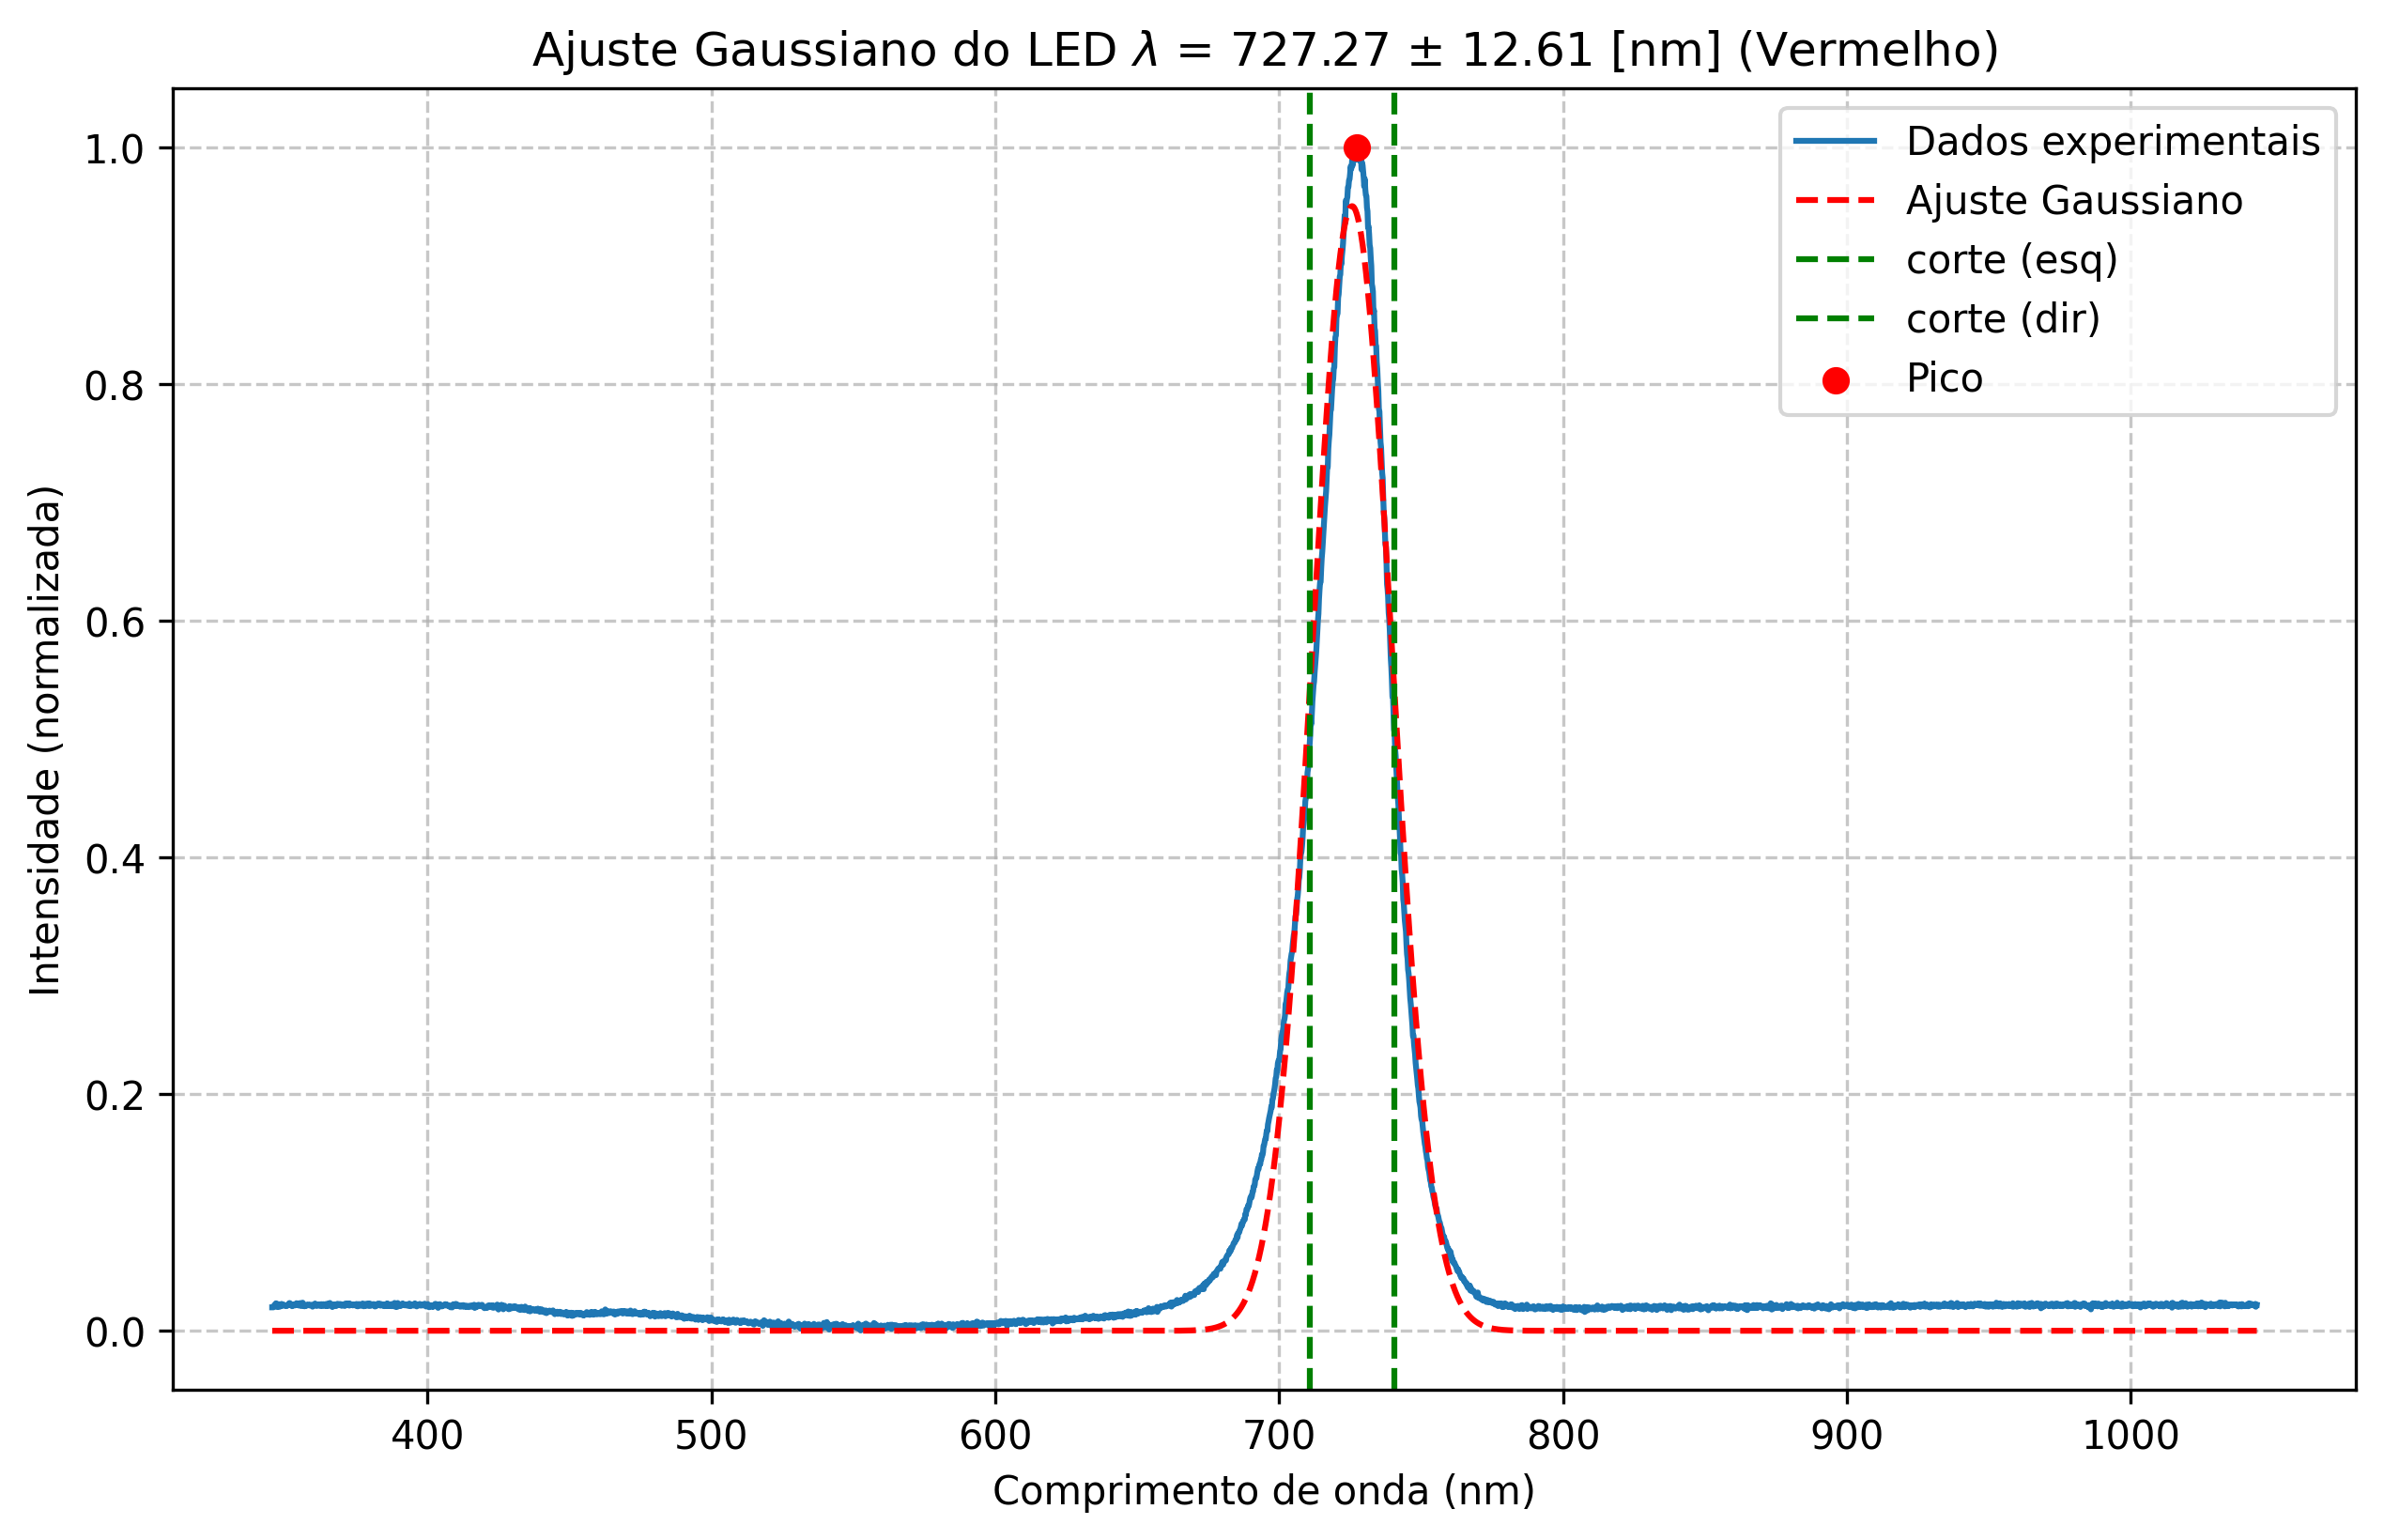

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Caminho do arquivo
caminho = 'Dados/Espectro-A-1/led6-a1-espectro.txt'
# Ler CSV
df = pd.read_csv(caminho, sep='\t', header=None, decimal=',')
x = df[0].to_numpy()
y = df[1].to_numpy()

# Normalizo os valores de y
y = (y - np.min(y)) / (np.max(y) - np.min(y))

# Índice do valor máximo de y
idx_max = np.argmax(y)
x_max, y_max = x[idx_max], y[idx_max]

# --------- 1) Cálculo da FWHM ---------
half_max = y_max / 2

# Pega os índices onde cruza a meia altura
indices = np.where(y >= half_max)[0]
x_left, x_right = x[indices[0]], x[indices[-1]]
FWHM = x_right - x_left
corte_left = x_left
corte_right = x_right
# Variância estimada
sigma_est = FWHM / (2 * np.sqrt(2 * np.log(2)))
var_est = sigma_est**2

print(f"Pico estimado = {x_max:.4f}")
print(f"FWHM estimado = {FWHM:.4f}")
print(f"sigma estimado = {sigma_est:.4f}")
print(f"variância estimada = {var_est:.4f}")

# --------- 2) Ajuste de curva (Gaussiana) ---------
def gaussiana(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Chutes iniciais: amplitude, média, sigma
p0 = [y_max, x_max, sigma_est]

popt, pcov = curve_fit(gaussiana, x, y, p0=p0)

A_fit, mu_fit, sigma_fit = popt
var_fit = sigma_fit**2

print(f"\n--- Ajuste da Gaussiana ---")
print(f"A = {A_fit:.4f}, mu = {mu_fit:.4f}, sigma = {sigma_fit:.4f}")
print(f"variância ajustada = {var_fit:.4f}")

# --------- Plot ---------
plt.figure(figsize=(10,6), dpi=300)

plt.plot(x, y, label="Dados experimentais")
plt.plot(x, gaussiana(x, *popt), 'r--', label="Ajuste Gaussiano")
# plt.axvline(x_left, color='g', linestyle='--', label="Meia altura (esq)")
# plt.axvline(x_right, color='g', linestyle='--', label="Meia altura (dir)")

plt.axvline(corte_left, color='g', linestyle='--', label="corte (esq)")
plt.axvline(corte_right, color='g', linestyle='--', label="corte (dir)")


plt.scatter(x_max, y_max, color="red", zorder=5, label="Pico")
plt.xlabel('Comprimento de onda (nm)')
plt.ylabel('Intensidade (normalizada)')
plt.title(r'Ajuste Gaussiano do LED $\lambda$ = 727.27 $\pm$ 12.61 [nm] (Vermelho)')

plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


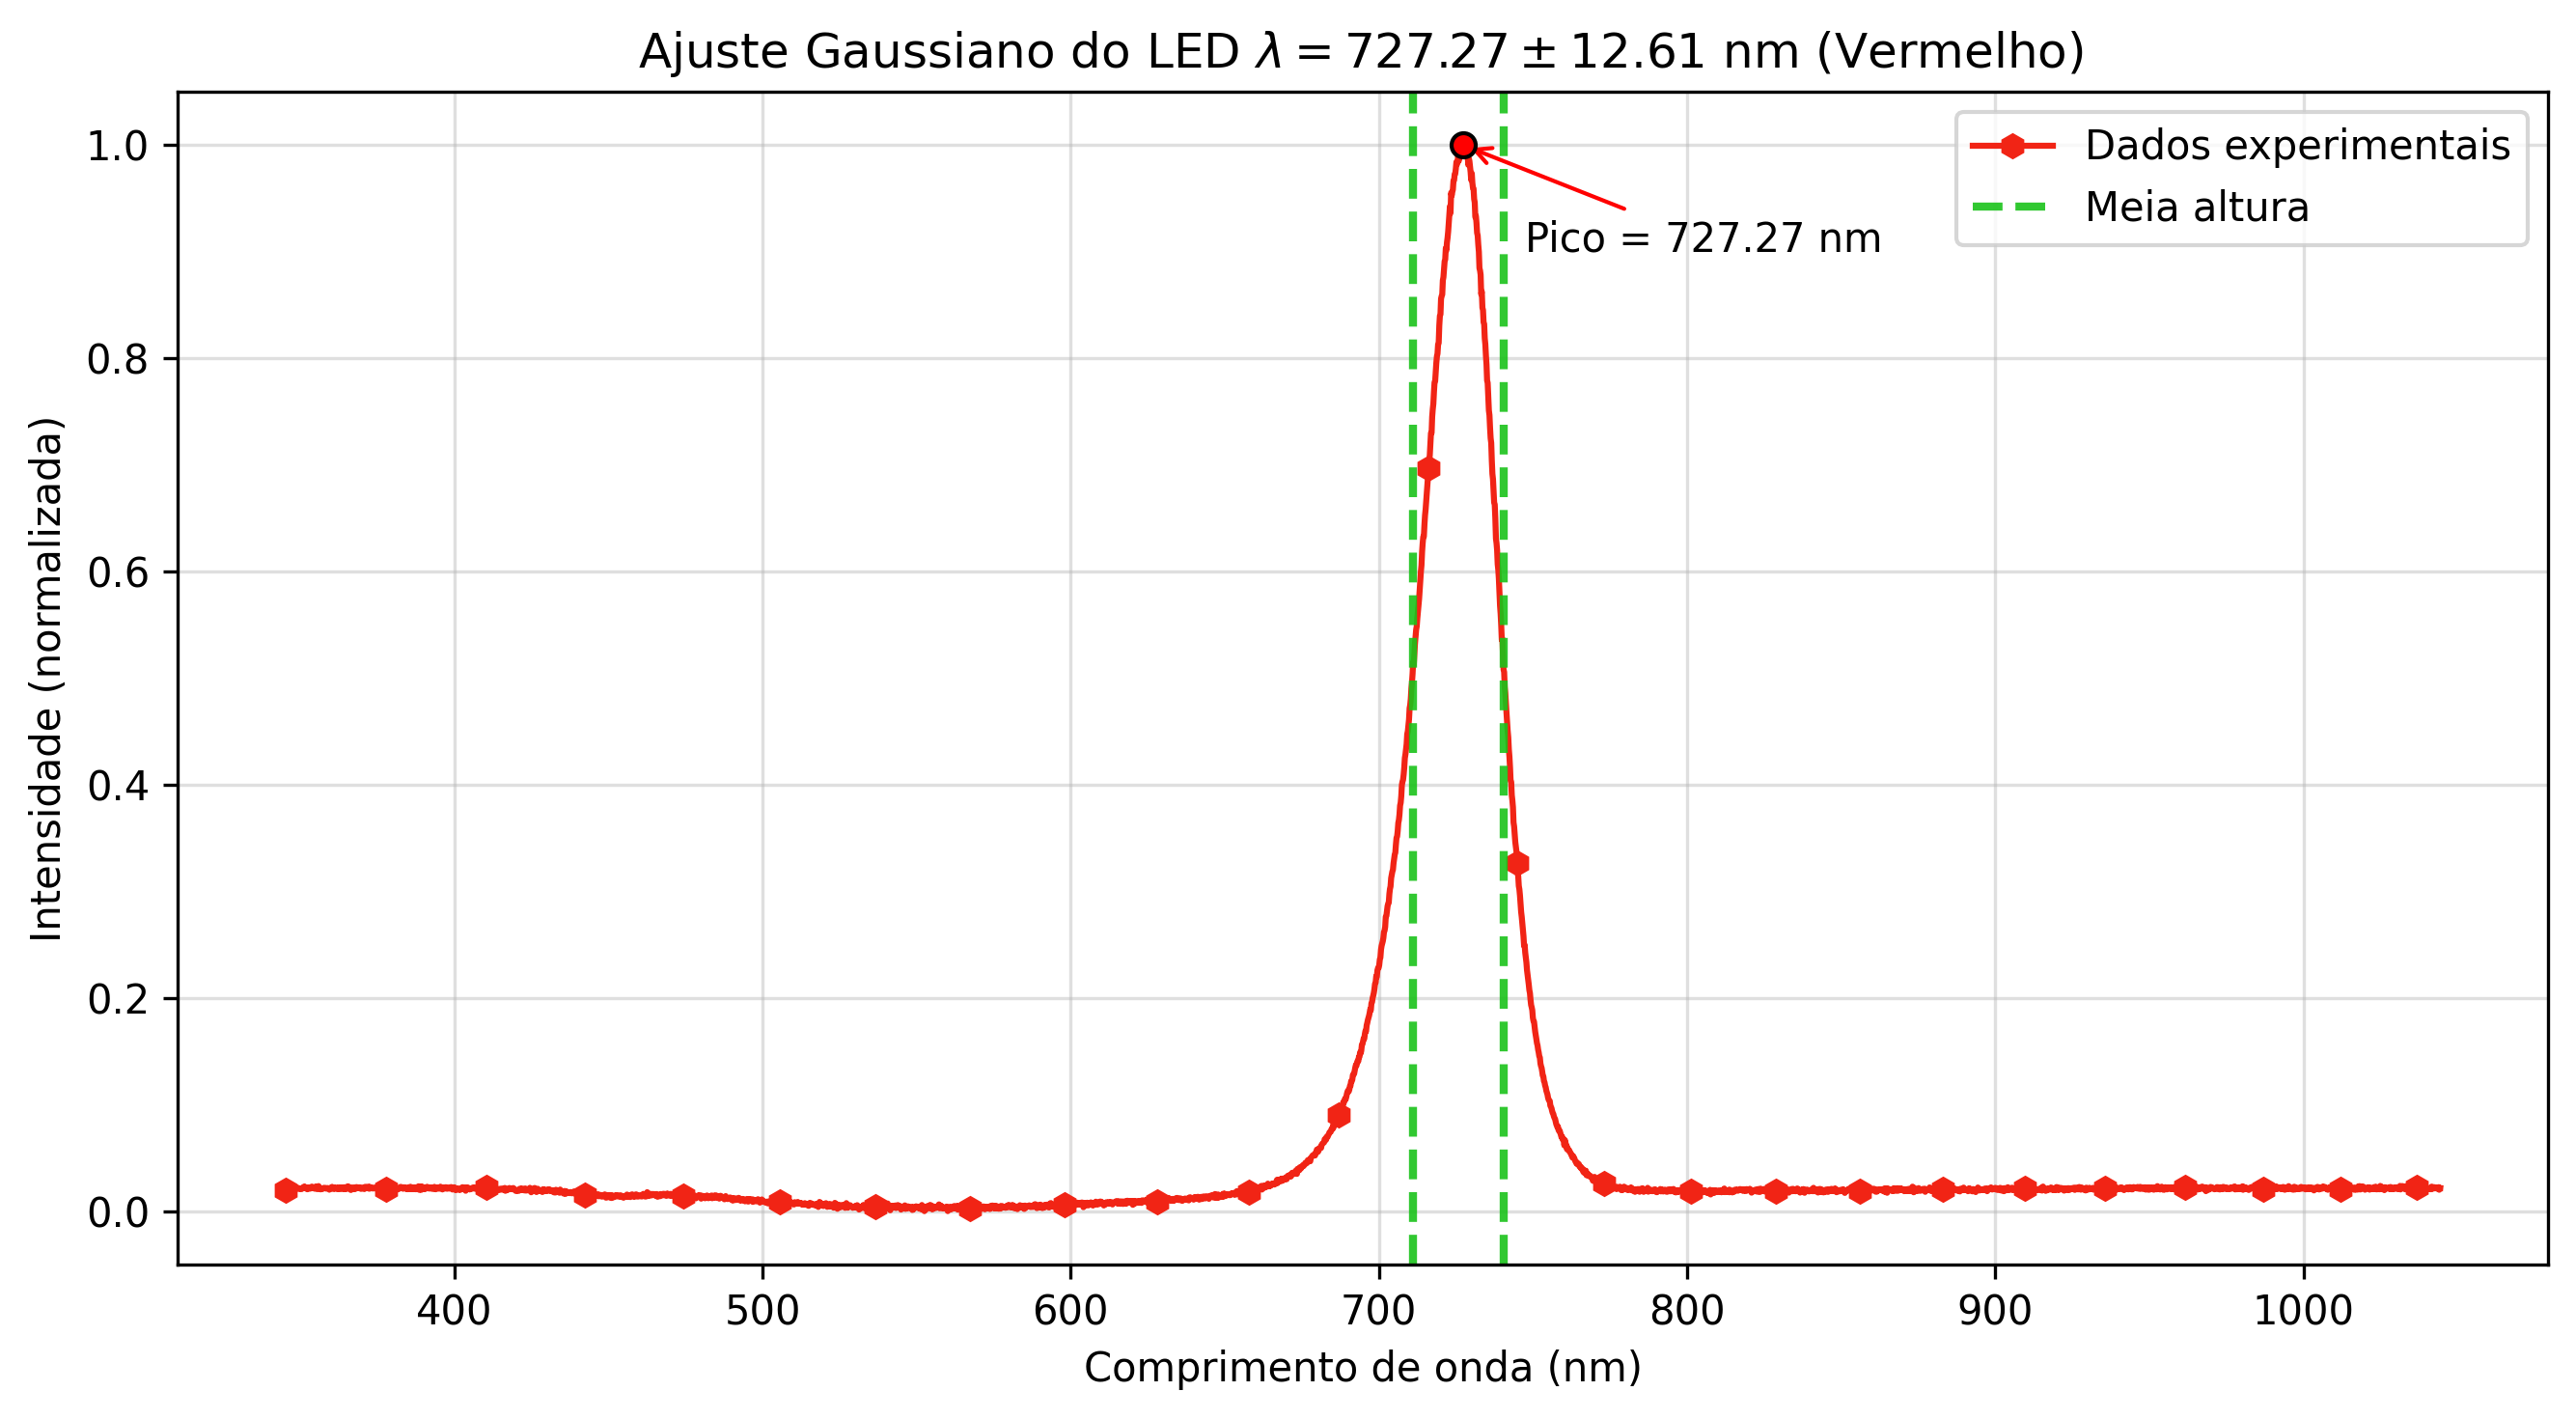

In [8]:
# Definição das cores pastéis
cor_vermelho   = "#0f12da"  # verde pastel mais contrastado
cor_azul    = "#F12415"  # azul pastel mais contrastado
cor_amarelo = "#1ac21a"  # amarelo pastel mais contrastado


plt.figure(figsize=(9,5), dpi=300)

# Dados experimentais em azul pastel
# plt.plot(x, y, color=cor_azul, alpha=1, label="Dados experimentais")
plt.plot(x, y, color=cor_azul, alpha=1, label="Dados experimentais", 
         marker='h', markevery=150, markersize=6, markerfacecolor=cor_azul, 
         markeredgecolor=cor_azul, markeredgewidth=0.5)

# Ajuste Gaussiano em vermelho pastel
# plt.plot(x, gaussiana(x, *popt), linestyle="--", color=cor_vermelho,
#          alpha=1, lw=2, label="Ajuste Gaussiano")

# Linhas de corte (FWHM) em amarelo pastel
plt.axvline(corte_left, color=cor_amarelo, linestyle='--', alpha=0.9, lw=2, label="Meia altura")
plt.axvline(corte_right, color=cor_amarelo, linestyle='--', alpha=0.9, lw=2)

# Pico como anotação em vermelho pastel
plt.scatter(x_max, y_max, color='red', edgecolor="k", zorder=5)
plt.annotate(f"Pico = {x_max:.2f} nm",
             xy=(x_max, y_max),
             xytext=(x_max+20, y_max-0.1),
             arrowprops=dict(arrowstyle="->", color='red'),
             fontsize=10, color='black')

plt.xlabel('Comprimento de onda (nm)')
plt.ylabel('Intensidade (normalizada)')
plt.title(r"Ajuste Gaussiano do LED $\lambda = 727.27 \pm 12.61$ nm (Vermelho) ")

plt.legend()
plt.grid(True, linestyle="-", alpha=0.4)
plt.tight_layout()
plt.show()
